In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#1. import data
df = df=pd.read_pickle(r"cust_final_20191030.pkl")

In [3]:
dfcd = df[(df["PRODUCT_GROUP"]=='CD') & (df["RISK_AGRF120"]==1)]

In [4]:
dfcd.TIME_DECISION_DATE.dt.year.unique()

array([2018, 2019, 2017, 2016, 2015, 2014, 2013, 2012], dtype=int64)

In [5]:
dfcd['TIME_GAP']=(dfcd['TIME_DECISION_DATE_max']-dfcd['ACTIVITY_DATE_max']).dt.days

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


4645
1


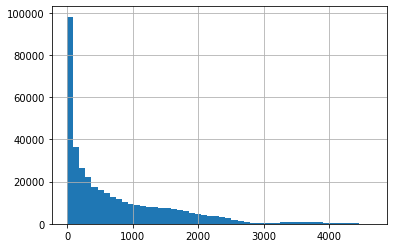

In [6]:
print(dfcd['TIME_GAP'].max())
print(dfcd['TIME_GAP'].min())
dfcd[dfcd["PRODUCT_GROUP"]=='CD']['TIME_GAP'].hist(bins=50)
dfcd[dfcd["PRODUCT_GROUP"]=='CL']['TIME_GAP'].hist(bins=50)

In [7]:
Xcd= dfcd.drop(columns=["PRODUCT_GROUP","TIME_DECISION_DATE_max","ACTIVITY_DATE_min","ACTIVITY_DATE_max","CLIENT_EXI_3M"])

In [8]:
loaded_modelcd = pickle.load(open(r"xgb_cd_fstq_wo_hc1.mod",'rb'))

In [9]:
feature_listcd = ['ALLOCATED_POINTS_std', 'ALLOCATED_POINTS_EARN_LAG2', 'ACTIVITY_ID_nunique', 'ALLOCATED_POINTS_EARN_LAG1', 'mesdq_max', 'month_nunique_FUEL_1000_Earn', 'ALLOCATED_POINTS_EARN_LAG3', 'month_nunique_DEBIT_1000_Earn', 'ACTIVITY_VALUE_std', 'month_nunique_DEBIT_180_Earn', 'month_nunique_GROCERY_1000_Earn', 'month_nunique_DEBIT_365_Earn', 'month_nunique_DEBIT_90_Earn', 'month_nunique_E_WALLET_365_by_1000_Earn', 'ACTIVITY_ID_count_DEBIT_180_Earn', 'month_nunique_FUEL_365_Earn', 'month_nunique_FUEL_180_by_1000_Earn', 'month_nunique_DEBIT_90_by_1000_Earn', 'ALLOCATED_POINTS_sum_E_WALLET_365_by_1000_Earn', 'ACTIVITY_ID_count_FUEL_1000_Earn', 'MOB', 'ACTIVITY_ID_count_FUEL_365_by_1000_Earn', 'ALLOCATED_POINTS_max_FUEL_180_Earn', 'ACTIVITY_DATE_nunique_E_WALLET_365_Earn', 'ACTIVITY_DATE_nunique_DEBIT_180_by_1000_Earn', 'ALLOCATED_POINTS_std_DEBIT_90_Earn', 'ALLOCATED_POINTS_median_DEBIT_90_Earn', 'ACTIVITY_DATE_nunique_DEBIT_365_by_1000_Earn', 'ACTIVITY_VALUE_sum_E_WALLET_180_by_1000_Earn', 'month_nunique_E_WALLET_1000_Burn', 'ALLOCATED_POINTS_max_FUEL_365_Earn', 'ALLOCATED_POINTS_mean_FUEL_180_Earn', 'ACTIVITY_VALUE_sum_FUEL_1000_Earn', 'ACTIVITY_VALUE_sum_E_WALLET_365_by_1000_Earn']

In [12]:
y_predcd= loaded_modelcd.predict_proba(Xcd[feature_listcd],ntree_limit= loaded_modelcd.best_ntree_limit)[:,1]
print("Blended Gini", 2*metrics.roc_auc_score(Xcd['RISK_FSTQPD30'], y_predcd)-1)

Blended Gini 0.2341194414180734


In [16]:
for i in np.arange(1,12):
    X_temp = Xcd[(Xcd["TIME_GAP"] >= (i-1)*360) & (Xcd["TIME_GAP"] < (i*360)-1)]
    y_predcd= loaded_modelcd.predict_proba(X_temp[feature_listcd],ntree_limit= loaded_modelcd.best_ntree_limit)[:,1]
    print("Bad Rate ",round(X_temp['RISK_FSTQPD30'].sum()*100/X_temp.shape[0],2),"% ","Count: ",X_temp.shape[0]," Iteration :",i," Time Gap Low: ",(i-1)*360," Time Gap High: ",(i*360)-1," Gini:", 2*metrics.roc_auc_score(X_temp['RISK_FSTQPD30'], y_predcd)-1)

Bad Rate  3.14 %  Count:  180174  Iteration : 1  Time Gap Low:  0  Time Gap High:  359  Gini: 0.2067002889093339
Bad Rate  3.19 %  Count:  59806  Iteration : 2  Time Gap Low:  360  Time Gap High:  719  Gini: 0.26647124795716026
Bad Rate  3.15 %  Count:  40152  Iteration : 3  Time Gap Low:  720  Time Gap High:  1079  Gini: 0.26055526386715244
Bad Rate  2.92 %  Count:  31276  Iteration : 4  Time Gap Low:  1080  Time Gap High:  1439  Gini: 0.27355520561052216
Bad Rate  2.99 %  Count:  27005  Iteration : 5  Time Gap Low:  1440  Time Gap High:  1799  Gini: 0.24546557367879407
Bad Rate  3.1 %  Count:  19200  Iteration : 6  Time Gap Low:  1800  Time Gap High:  2159  Gini: 0.276950670620304
Bad Rate  3.69 %  Count:  12400  Iteration : 7  Time Gap Low:  2160  Time Gap High:  2519  Gini: 0.29670499846784937
Bad Rate  3.62 %  Count:  4639  Iteration : 8  Time Gap Low:  2520  Time Gap High:  2879  Gini: 0.32129943232045655
Bad Rate  3.43 %  Count:  1515  Iteration : 9  Time Gap Low:  2880  Time Ga

In [20]:
for yr in np.arange(2012,2020):
    X_temp = Xcd[Xcd["TIME_DECISION_DATE"].dt.year==yr]
    y_predcd= loaded_modelcd.predict_proba(X_temp[feature_listcd],ntree_limit= loaded_modelcd.best_ntree_limit)[:,1]
    print("Bad Rate ",round(X_temp['RISK_FSTQPD30'].sum()*100/X_temp.shape[0],2),"% ","Count: ",X_temp.shape[0]," Year: ",yr," Gini:", 2*metrics.roc_auc_score(X_temp['RISK_FSTQPD30'], y_predcd)-1)

Bad Rate  5.71 %  Count:  35  Year:  2012  Gini: 0.3181818181818181
Bad Rate  1.37 %  Count:  219  Year:  2013  Gini: 0.287037037037037
Bad Rate  0.77 %  Count:  781  Year:  2014  Gini: 0.0823655913978496
Bad Rate  0.48 %  Count:  4798  Year:  2015  Gini: 0.2389710903710447
Bad Rate  0.31 %  Count:  21957  Year:  2016  Gini: 0.16678439688264945
Bad Rate  0.15 %  Count:  85491  Year:  2017  Gini: 0.07865698287374356
Bad Rate  3.87 %  Count:  204648  Year:  2018  Gini: 0.22797113648842604
Bad Rate  6.02 %  Count:  66747  Year:  2019  Gini: 0.09961970618895788
